<a href="https://colab.research.google.com/github/RikiToubkin/PRA_3024/blob/main/Assignment_Set2_Challenge2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
! pip install -q 'gwosc==0.5.4'
! pip install pycbc
! pip install matplotlib

Part 1.


In [26]:
# Loading the data and converting the data into a time series.

import gwosc
import numpy as np
import pycbc
from pycbc.types import FrequencySeries, TimeSeries
import matplotlib.pyplot as plt
import warnings
import lal
d = np.load('/content/noise_ts_4096Hz.npy')

warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")


time = d[:, 0]
d = pycbc.types.TimeSeries(d[:, 1], delta_t = time[1]-time[0])
data = d
duration = len(d)/4096  # Check for the time duration of the data.
# print(duration)

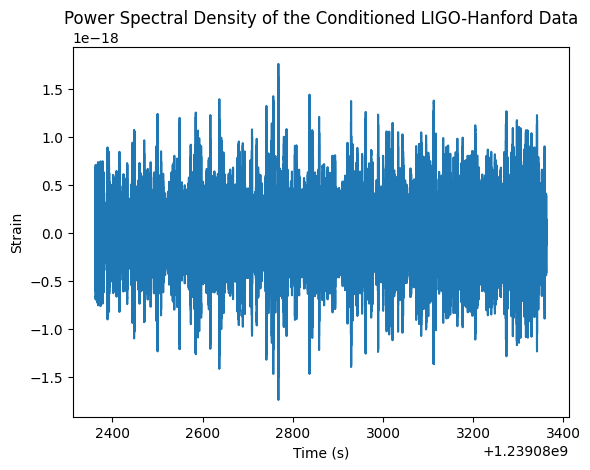

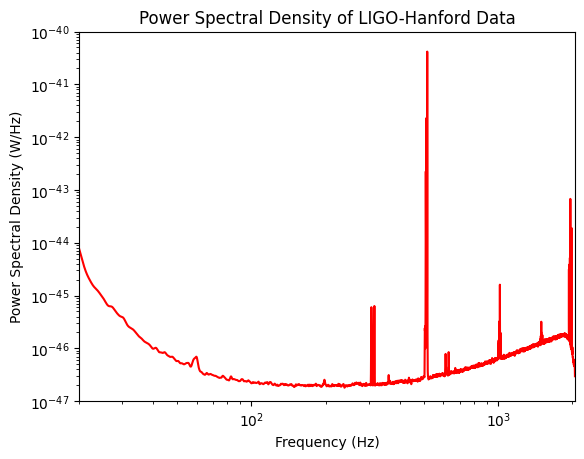

In [27]:
#Conditioning the data and plotting its Power Spectral Density (PSD).

from pycbc.psd import welch, interpolate, inverse_spectrum_truncation
import pylab
import pycbc.noise
import pycbc.psd

conditioned = data.crop(2, 2)

#pylab.plot(conditioned.sample_times, conditioned)
#pylab.xlabel('Time (s)')
#pylab.show()

fd = conditioned.to_frequencyseries()
plt.plot(time, data)
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.title("Power Spectral Density of the Conditioned LIGO-Hanford Data")
plt.show()
freq = 1/data.delta_t   # Check for the frequency of the data.
#print("Frequency: " + str(freq)).

psd = interpolate(data.psd(2), fd.delta_f)
psd = inverse_spectrum_truncation(psd, int(2*data.sample_rate), low_frequency_cutoff=15.0, trunc_method="hann")
pylab.loglog(psd.sample_frequencies, psd, label="H1", color='r')
pylab.xlabel("Frequency (Hz)")
pylab.ylabel("Power Spectral Density (W/Hz)")
pylab.title("Power Spectral Density of LIGO-Hanford Data")

pylab.xlim(20, 2048)   # Chosen the frequency limit as 2048Hz which is the Nyquist frequency of the data.
pylab.ylim(1e-47,1e-40)
pylab.show()

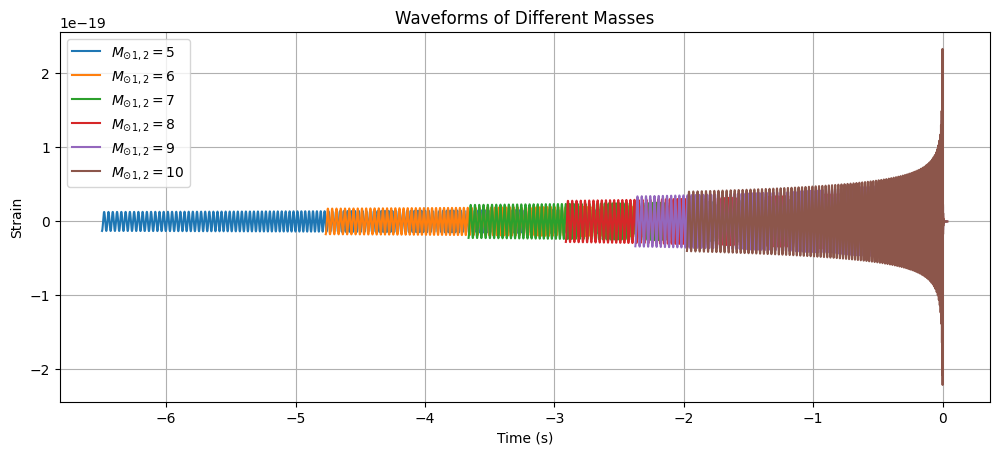

In [30]:
# Generating and plotting waveforms for bodies of varying solar masses (between 5 and 10 solar masses).

from pycbc.waveform import get_td_waveform
pylab.figure(figsize=pylab.figaspect(0.4))
for m in [5, 6, 7, 8, 9, 10]:
    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=m,
                         mass2=m,
                         delta_t=1.0/4096,
                         f_lower=30)

    pylab.plot(hp.sample_times, hp, label='$M_{\odot 1,2}=%s$' % m)
pylab.legend()
pylab.grid()
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.title("Waveforms of Different Masses")
pylab.show()

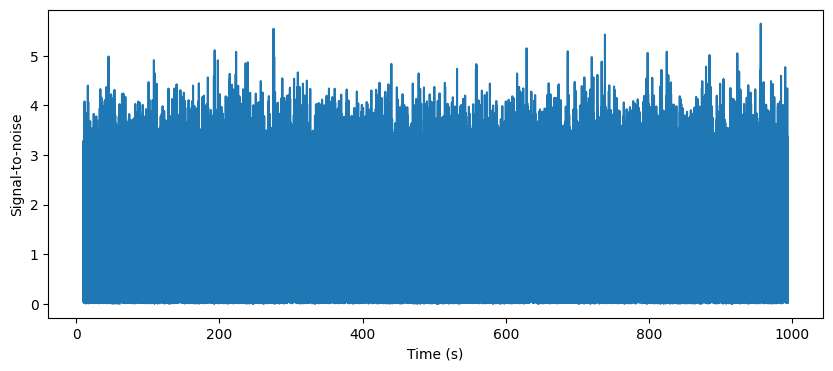

We found a signal at 956.0273437496252s with SNR 5.646497575393693


In [31]:
#Calculating and plotting the SNR (Signal to noise ratio) of the conditioned data.

from pycbc.filter import matched_filter

hp.resize(len(conditioned))
template = hp.cyclic_time_shift(hp.start_time)

snr = matched_filter(template, conditioned, psd=psd, low_frequency_cutoff=15)

snr = snr.crop(4 + 4, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time,abs(snrp)))

Since the SNR detected was less then 8, we can conclude that there is no gravitational wave signal present in the data.






Part2.

In [32]:
# Whitening the data.

white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()
white_data = white_data.crop(4,4)

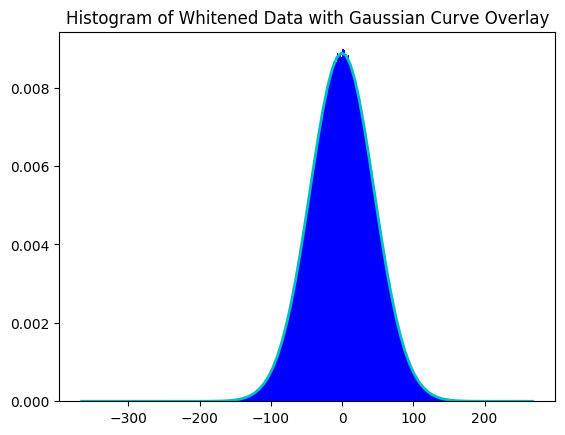

Mean=0.00, Standard Deviation=44.89)


In [33]:
# Plotting a histogram of the whitened data with a Gaussian fit overlay.
from scipy.stats import norm

mean = np.mean(white_data)
std_dev = np.std(white_data)

hist=plt.hist(white_data,bins='auto', density=True, color = 'b')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std_dev)
plt.plot(x, p, color='c', linewidth=2);
plt.title("Histogram of Whitened Data with Gaussian Curve Overlay")
plt.show()
print(f"Mean={mean:.2f}, Standard Deviation={std_dev:.2f})")

The above histogram follows a Gaussian distribution with zero mean.


Part 3.


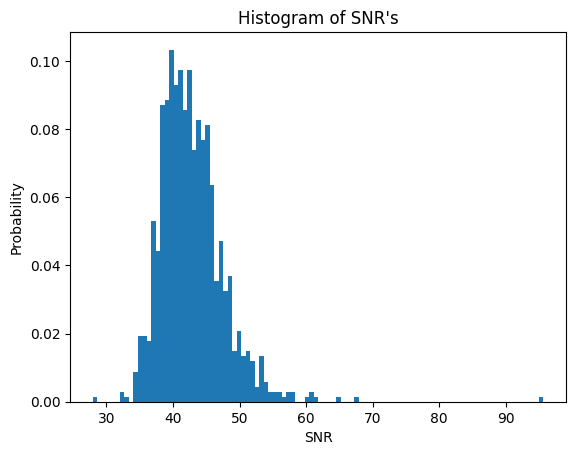

SNR varies. Therefore, the stationary assumption does not hold.


In [34]:
# Testing the stationary assumption.

# Regenerating the waveforms.
from pycbc.waveform import get_fd_waveform
f_final = 2048.0


for m in [5, 6, 7, 8, 9, 10]:
  hp1, hc1 = get_fd_waveform(approximant="TaylorF2",
                          mass1=m,
                          mass2=m,
                          delta_f=1.0/200.0,
                          distance=500,
                          f_lower=20,
                          f_final=2048)


# Calculating the PSD
psds = pycbc.psd.interpolate(pycbc.psd.welch(data), hp1.delta_f)

# Calculating the SNR
snr1 = np.sqrt(pycbc.filter.sigmasq(hp1, psds))

# Parameters for data slicing
slices = 1000
data_slice_length = len(data) // slices

snr_all = []

# Iterating over each data slice
for i in range(slices):
    data_piece = data[i * data_slice_length: (i + 1) * data_slice_length]
    psds_piece = pycbc.psd.interpolate(pycbc.psd.welch(data_piece), hp1.delta_f)
    snr_piece = np.sqrt(pycbc.filter.sigmasq(hp1, psds_piece))
    snr_all.append(snr_piece)

#Plotting the histogram
plt.hist(snr_all, 100, density=True)
plt.title("Histogram of SNR's")
plt.xlabel("SNR")
plt.ylabel("Probability")

plt.show()

if len(set(snr_all)) > 1:
    print("SNR varies. Therefore, the stationary assumption does not hold.")
else:
    print("SNR is constant. Therefore, the stationary assumption holds.")

Since the SNR values vary, we have proven that the noise is not stationary Gaussian.

All calculation and coding techniques were adapted from the GW_BigData_tutorial-2 found in the module section of the PRA3024 Canvas page.

This tutorial can be found at: https://canvas.maastrichtuniversity.nl/courses/17323/files/3534550/download?download_frd=1